In [2]:

import pandas as pd
import numpy as np
import random
import pickle


In [3]:
#df = pickle.load(open('dataframes/data_frame_RI10_p1.pcl','rb')) #берем дневную
df = pickle.load(open('dataframes/data_frame_v2_SI04_p1.pcl','rb')) #дневная сишка

In [4]:
date_l = list(df['<DATE>'])

In [5]:
len(date_l)

448275

In [6]:
#df['hm']=round(df['<TIME>']/1000,0) #добавим еще одну фичу - час и десятки минут

In [7]:
df.head()

,<DATE>,<TIME>,<LAST>,vpin,oper_num,vpin_2,vpin_3,vpin_4,vpin_5,vpin_10,...,price_skew_dif_2,price_skew1_dif_2,price_skew_dif_3,price_skew1_dif_3,price_skew_dif_5,price_skew1_dif_5,price_skew_dif_10,price_skew1_dif_10,price_skew_dif_50,price_skew1_dif_50
100474,20180924,120818,66620.0,0.071429,11,0.054545,-0.269406,-0.011450,-0.358852,-0.322645,...,1.247036,0.000000,-6.335728,0.000000,-5.794057,0.000000,2.164863,0.953726,2.074408,-2.169483
100475,20180924,120819,66616.0,-1.000000,1,0.000000,0.017544,-0.276018,-0.015209,-0.323349,...,1.247183,-0.183629,0.738659,3.488748,-5.788312,-2.313234,0.118067,2.678036,0.623486,-0.674297
100481,20180924,120820,66620.0,0.363636,6,0.250000,0.153846,0.113924,-0.218107,-0.324831,...,0.000000,0.000000,0.261742,0.000000,-5.782697,0.000000,1.450098,0.631935,2.073206,-2.022654
100499,20180924,120820,66624.0,1.000000,18,0.895522,0.867647,0.731707,0.633508,-0.234266,...,1.213381,-0.571639,-7.071989,-3.488748,-5.777211,-3.034132,-3.363578,0.631959,0.161836,-2.998179
100510,20180924,120820,66628.0,1.000000,11,1.000000,0.949640,0.935714,0.857143,-0.101639,...,1.062067,0.154492,11.643873,2.024836,5.335514,2.314944,-7.970842,-0.023071,-0.137593,-1.648985


In [8]:

#выкиним все наны, которые остались от предыдущих преобзований
df.dropna(axis=0, how='any',inplace=True)
price_l = list(df['<LAST>'])
print(len(price_l))
#разметим данные поставим категорию, которая будет показывать 1 в случае если мы достигли +profit_loss за 200 следующих тиков
#либо -1 если мы достигли -profit_loss рублей
# и 0 если мы ничего не достигли

def set_sb_class():
    look_forward = 200 #на сколько тиков смотрим вперед. если не то ни другое то устанавливаем 0
    
    result_l = [0]*len(price_l)
    profit_loss  = 40 #тейк профит или стоп лосс
    for i in range(len(price_l)-look_forward):
        sb_category = 0
        try:
            start_price = price_l[i]
        except:
            print(i)
        for j in range(i+1,i+look_forward): #теперь пробежимся вперед от каждой цены и выставим 1 или -1 что быстрее = profit_losss
            if (price_l[j]-start_price)>=profit_loss:
                sb_category = 1 #/(j-i)
                break
            if (price_l[j]-start_price)<=-profit_loss:
                sb_category =-1 #/(j-i)
                break
        result_l[i]=sb_category
    return result_l

448275


In [9]:
df['target']=set_sb_class()

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

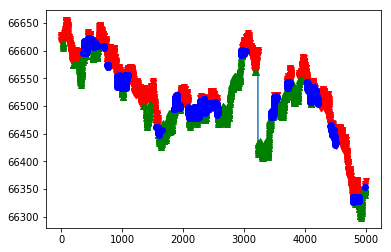

In [11]:
#визуализация резаметки
prom_target = df.target[0:5000]
prom_p = price_l[0:len(prom_target)]
red_v = [[j,prom_p[j]] for j,x in enumerate(prom_target) if x<0]
green_v = [[j,prom_p[j]] for j,x in enumerate(prom_target) if x>0]
zerro_v = [[j,prom_p[j]] for j,x in enumerate(prom_target) if x==0]
plt.plot(prom_p)
plt.plot(*zip(*red_v ), marker='v', color='r', ls='')
plt.plot(*zip(*green_v), marker='^', color='g', ls='')
plt.plot(*zip(*zerro_v), marker='o', color='b', ls='')
plt.show()

In [12]:
#удалим лишние колонки, котоыре будут сбивать обучение - дата, время и абсолютные значения цены и фильтров

In [13]:
columns_to_del = list(df.columns)[:3]
columns_to_del+=['kalman','kalman_slow']

In [14]:
columns_to_del

['<DATE>', '<TIME>', '<LAST>', 'kalman', 'kalman_slow']

In [15]:
for i in columns_to_del:
    del df[i]

In [16]:
#делим на train и test упрощенно - просто отрезаем хвост из test_size значений
def my_train_test_split(f,l,test_size):
    test_length = int(len(f)*test_size)
    return f[:-test_length],f[-test_length:],l[:-test_length],l[-test_length:]

In [17]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

In [18]:
df = df.dropna(axis=0, how='any')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
features = df[df.columns[:-1]].values


#пастеризация - нормируем от -1 до 1 и округлим до 0.1 - это позволит модели искать взаимосвязь между
#показателями а не внутри одного - повышает качество на out_of_sample
scaler = StandardScaler()
scaler.fit(features)
features =scaler.transform(features)

features = np.around(features,decimals=1)




labels =df['target'].values

test_proc = 0.03 #тестовый размер 5% от train
train_features, test_features, train_labels, test_labels =my_train_test_split(features,labels,test_size = test_proc)

In [19]:
date_l[-len(test_features)],date_l[-1]

(20190226, 20190307)

In [20]:
#тестовая выборка - 9 дня

In [21]:
#посмотрим сколько у нас плюсов в категориях и минусов
len(df[df.target>0])/len(df[df.target<0])

1.0537918289221833

In [22]:
import lightgbm as lgb

from sklearn.metrics import mean_squared_error

In [23]:
from sklearn.metrics import mean_squared_error
test_predicted_labels = []
def test(model):    
    tolerance = 0.5
    train_predicted_labels = model.predict(train_features)
    test_predicted_labels = model.predict(test_features)
    train_errors = mean_squared_error(train_labels,train_predicted_labels)
    test_errors = mean_squared_error(test_labels,test_predicted_labels)
    print('Train MSE',train_errors)
    print('Test MSE',test_errors)
    plt.plot(train_labels[:1000])
    plt.plot(train_predicted_labels[:1000])
    plt.show()
    plt.plot(test_labels[:1000])
    plt.plot(test_predicted_labels[:1000])
    plt.show()
    for j in range(10):
        print(test_labels[j],test_predicted_labels[j])
    count_p_error= 0
    count_m_error = 0
    #test = test_predicted_labels
    test = test_predicted_labels
    for j in range(len(test)):
        if abs(test[j])>tolerance:
            #print(test_predicted_labels[j],test_labels[j])
            if np.sign(test[j])==np.sign(test_labels[j]):
                count_p_error+=1
            else:
                count_m_error+=1
    if count_m_error == 0: count_m_error = 1
    print('PF:',count_p_error,count_m_error,count_p_error/count_m_error)
    
    big_num_errors_1 = []
    big_num_errors_2 = []

    
    for i,x in enumerate( test):
        if x>tolerance:
            big_num_errors_1.append(x)
            big_num_errors_2.append(test_labels[i])
    print('MSE+',mean_squared_error(big_num_errors_1,big_num_errors_2))
    print('PR+',sum([x for x in big_num_errors_2 if x>0])/sum([x for x in big_num_errors_2 if x<0]))
    big_num_errors_1 = []
    big_num_errors_2 = []
    print()
    for i,x in enumerate( test):
        if x<-tolerance:
            big_num_errors_1.append(x)
            big_num_errors_2.append(test_labels[i])
    print('MSE-',mean_squared_error(big_num_errors_1,big_num_errors_2))
    print('PR-',sum([x for x in big_num_errors_2 if x<0])/sum([x for x in big_num_errors_2 if x>0]))
    return test_predicted_labels
 

In [24]:
model = lgb.LGBMRegressor(n_estimators=1000,max_depth=20,num_leaves=100,learning_rate=0.1,
                         subsample_for_bin=20000)
model.fit(train_features,train_labels)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=20,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, num_leaves=100, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=20000, subsample_freq=0)

Train MSE 0.040165192401106095
Test MSE 0.7246861835530892


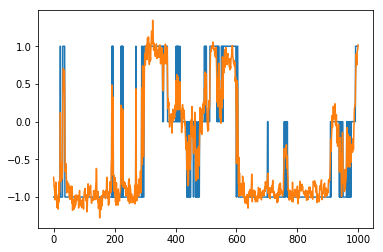

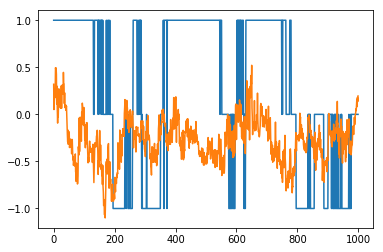

1 0.31970128804736764
1 0.05103480934685607
1 0.1449417393792602
1 0.22065471668395029
1 0.17725111498478063
1 0.2516277225314715
1 0.49527940512573976
1 0.47890035648147655
1 0.4920636340739335
1 0.4250728486022736
PF: 1454 1906 0.7628541448058762
MSE+ 0.9020616146727634
PR+ -1.953125

MSE- 0.8416989630669011
PR- -1.8560311284046693


In [25]:
test_predicted_labels = test(model)

In [26]:
#выше два числа важные - PR+, PR- соотношения правильно угаданных для плюсовых и минусовых сделок

In [27]:
columns_model = list(df.columns)
best_f_l = []
for i,x in enumerate(model.feature_importances_):
    best_f_l.append([columns_model[i],x])
best_f_l.sort(key=lambda x: x[1],reverse = True)
best_f_l[:20] #лучшие 20 фич

[['ang_lr_5000', 2389],
 ['rsi_1000', 2317],
 ['vpin_5000', 2219],
 ['price_skew1_50', 2096],
 ['sec_500', 1924],
 ['min_max_1000_dist', 1867],
 ['price_std1_50', 1828],
 ['price_skew_50', 1801],
 ['vpin_1000', 1798],
 ['max_1000_dist', 1783],
 ['ang_lr_1000', 1757],
 ['min_1000_dist', 1754],
 ['price_skew1_10', 1730],
 ['price_std_50', 1710],
 ['mean_vol_1000', 1704],
 ['min_500_dist', 1702],
 ['min_300_dist', 1674],
 ['max_500_dist', 1654],
 ['min_max_500_dist', 1652],
 ['price_skew1_2', 1649]]

In [28]:
import numpy as np
import pandas as pd
import simdkalman
import talib
import random
from simdkalman.primitives import predict, update
#эмулятор исполнения, он же завязан на транзак, он же считает всю статистику и строит графики
class Executor:
    def __init__(self):
        self.quantity = 0 #текущее количество на руках
        self.cost = 0.0 #себестоимость позиции
        self.market_value = 0.0 #рыночная стоимость 
        self.r_pnl = 0.0 #накопленная прибыль (только закрытые позиции)
        self.average_price = 0.0 #средняя цена за штуку на руках
        self.open_orders = []#заявки (снятые выкидываем)
        self.my_trades = []#сделки
        self.REAL_TRADE = False #если True то сделки и заявки подает транзак по callback
        self.on_price_prob = 1.0 #вероятность исполнения тика
        self.total_profit = 0.0 #общая прибыль с учетом незакрытых сделок
        self.equity = [] #история эквити
        self.position = [] #история позиции
        self.plt_buy = [] #для графика сделок
        self.plt_sell = [] #для графика сделок
        self.plt_price = [] #для графика сделок
        self.total_volume = 0 #общее количество проторгованных лотов
        self.price_of_last_deal = 0 #цена последней сделки
        self.stop_losses = [] #таблица стоплоссов - при достижении цены или окончания времени - выставляется заявка
        self.out_order_delta = 0.0 #снимаем заявки, которые ушли от текущей цены
        self.deals_for_pf = [] #результаты сделок
        self.max_position = 1000 #максимальная поза. если идет превышение, то игнорируем заявки

                
    def fill(self, pos_change, exec_price):
        self.my_trades.append([exec_price,pos_change])
        n_pos =self.quantity+pos_change
        
        direction = np.sign(pos_change)
        prev_direction = np.sign(self.quantity)
        qty_closing = min(abs(self.quantity), abs(pos_change)) * direction if prev_direction != direction else 0
        
        qty_opening = pos_change if prev_direction == direction else pos_change - qty_closing
        

        new_cost = self.cost + qty_opening * exec_price
        
        if self.quantity != 0:
            new_cost += qty_closing * self.cost / self.quantity
            profit = qty_closing * (self.cost / self.quantity - exec_price)
            self.r_pnl += profit
            self.deals_for_pf.append(profit)
            
        self.quantity = n_pos
        self.cost = new_cost
        
        if self.quantity != 0:
            self.average_price = self.cost / self.quantity
        else: 
            self.average_price = 0
            
        if pos_change>0:
            self.plt_buy.append([len(self.plt_price)+1,exec_price])
        else:
            self.plt_sell.append([len(self.plt_price)+1,exec_price])
            
        self.total_volume+=abs(pos_change)
        self.price_of_last_deal = exec_price

    def u_pnl(self, price):
        self.market_value = self.quantity * price
        return self.market_value - self.cost
        
        

    def add_order(self,price,qnt,sl_price = 0,sl_time = 10000): #добавить ордер. минус - продажа
        #tp это знак ордера продажа или покупка
        
        tp=np.sign(qnt)
        
        if (tp<0 and self.quantity<=-self.max_position) or (tp>0 and self.quantity>=self.max_position):
            #мы превышаем максимальную позу,пропускаем
            pass
        else:
            if qnt!=0:
                if self.REAL_TRADE:

                    if tp>0:
                        print(trans_quik('B',price,abs(qnt)))
                    else:
                        print(trans_quik('S',price,abs(qnt)))
                else:
                    if self.on_price_prob<1.0:
                        self.open_orders.append([price,qnt,tp,0])
                    else:
                        self.fill(qnt,price) 
            if sl_price>0:
                self.stop_losses.append([sl_price,-qnt,sl_time])

    def cancel_orders(self,tp): #отменить все ордера по направлению. например -1 снять все ордера на продажу
        for x in reversed(self.open_orders):
        
            
            if x[2] == tp and x[3]<1:
                if self.REAL_TRADE and x[5]!=None:
                    trans_quik('C',0,0,x[4])
                else:
                    self.open_orders.remove(x)
    def cancel_order(self,order):
        if not self.REAL_TRADE:
            self.open_orders.remove(order)
        else:
            trans_quik('C',0,0,order[4])
    def cancel_out_orders(self,price,delta):#отменить все ордера с делтой цены больше чем
        
        for x in reversed(self.open_orders):
        
            
            if x[3]<1 and abs(x[0]-price)>delta:
                if self.REAL_TRADE and x[5]!=None:
                    trans_quik('C',0,0,x[4])
                else:
                    self.open_orders.remove(x)
            
    def order_on_price(self,price):
        if self.on_price_prob<1.0:
            for x in self.open_orders:
                if x[3]<1 and x[0]==price:
                    return True
        return False
    
    def update(self,price,update_stat=True):#запускается каждый раз при измении цены. проверяет пересекла тек цена цену ордера или нет
        for x in reversed(self.stop_losses):
            x[2]-=1
            removed = False
            if x[0]==price:
                    
                self.add_order(price,x[1])
                self.stop_losses.remove(x)
                removed = True
                    
            if x[2]<=0 and not removed:
                self.add_order(price,x[1])
                self.stop_losses.remove(x)
        
        if not self.REAL_TRADE:
            
            
            for x in reversed(self.open_orders):
        
            
                if x[3]>0: #выкинем все исполненные ордера
                    self.open_orders.remove(x)
                    
            for x in self.open_orders:
                if x[3]<1: #только открытые ордера
                    if x[2]<0 and price>x[0]: #продажа и цена ушла выше - исполнен
                        x[3]= 1
                        self.fill(x[1],x[0])
                    elif x[2]>0 and price<x[0]:#покупка и цена ушла ниже - исполнен
                        x[3]=1
                        self.fill(x[1],x[0])
                    if self.on_price_prob>0.0:
                        if price==x[0] and random.random()<self.on_price_prob:
                            x[3] = 1
                            self.fill(x[1],x[0])
        else:
            pass
            #for x in self.open_orders:
            #здесь надо поставить выкидывание ордеров неправильных

        if update_stat:
            self.equity.append(self.r_pnl+self.u_pnl(price))
            self.position.append(self.quantity)
            self.plt_price.append(price)
            self.total_profit = self.r_pnl+self.u_pnl(price)
        if self.out_order_delta>0:
            self.cancel_out_orders(price,self.out_order_delta)
                
    def var_margin(self,price):#считаем текущую вар маржу
        margin = 0
        for x in self.open_orders:
            margin+=(price-x[0])*x[1]*x[3] #(тек цена минус цена оредра ) умножить на колво и на признак исполнения)
        return margin
    def get_position(self):#возвращает число лотов на руках    
        return sum([x[1] for x in self.open_orders if x[3]==1])

    def get_position_price(self,): #считает среднюю цену лотов на руках
        return sum([sum([x[1]*x[0] for x in self.open_orders if x[3]==1])])/sum([x[1] for x in self.open_orders if x[3]==1])
    
    def get_ppd(self):
        if self.total_volume>0:
            return (self.total_profit/self.total_volume)*2
        else:
            return 0.0
    def get_profit_factor(self):
        plus_deals = sum([x for x in self.deals_for_pf if x>0])
        minus_deals = sum([x for x in self.deals_for_pf if x<=0])
        if minus_deals==0:
            minus_deals = 1
        return plus_deals/minus_deals
    
        
    def plot_stat_3(self):
        
        plt.plot(self.plt_price)
        plt.plot(*zip(*self.plt_sell), marker='v', color='r', ls='')
        plt.plot(*zip(*self.plt_buy), marker='^', color='g', ls='')
        plt.show()
        plt.plot(self.equity, color = 'b')
        plt.show()
        plt.plot(self.position)
        plt.show()
    
    def plot_deals(self,last = 0): #тут недоделано про last
        if last == 0:
            last_for_sell = 0
            last_for_buy = 0
        
            
        plt.plot(exe.plt_price[-last:])
        plt.plot(*zip(*exe.plt_sell[-last_for_sell:]), marker='v', color='r', ls='')
        plt.plot(*zip(*exe.plt_buy[-last_for_buy:]), marker='^', color='g', ls='')
        plt.show()
    

    
    ### добавить функции по работе с ордерами из api hft_battle
    


In [29]:
def back_test(tolerance,take_profit,stop_loss_time,start=0,end = 0, show_graphs = True):
    exe = Executor()
    exe.on_price_prob = 1.0 #вероятность исполнения по тику 100%
    exe.out_order_delta = 30 #для меньшей вероятности они образуются неисполненные ордера. снимаем их если цена ушла больше чем
    exe.max_position = 100 #ограничение максимальной позы. если больше, то просто игнорируеми ордера
    if end==0:
        end = len(test_predicted_labels)
    test = test_predicted_labels[start:end]
    
    l= len(test)
    
    test_data = df[-l:]
    test_price = price_l[-l:]

    for t in range(l):
        price = test_price[t]
        betta = test[t]
        if betta>tolerance and not exe.order_on_price(price):
            exe.add_order(price,1,sl_price = price+take_profit,sl_time = stop_loss_time)
        elif betta<-tolerance and not exe.order_on_price(price):
            exe.add_order(price,-1,sl_price=price-take_profit,sl_time = stop_loss_time)

        exe.update(price)
    if show_graphs:
        exe.plot_stat_3()

    return round(exe.r_pnl,2),round(exe.get_ppd(),3),abs(round(exe.get_profit_factor(),3))

In [30]:
results = []
#попробуем перебарть 
for i in range(200):
    if i%10==0:
        print('|',end='')
        
    a,b,c = random.randint(1,10)/10,random.randint(1,20)*10,random.randint(1,10)*10
    r = back_test(tolerance=a,take_profit=b,stop_loss_time=c,show_graphs = False)
    results.append((a,b,c)+r)

||||||||||||||||||||

In [31]:
results.sort(key=lambda x: x[4],reverse = True)
# 3 - сортировка по общей сумме
# 4 - по средней прибыли на сделку
# 5 - по PF

In [32]:
results[0:20]


[(1.0, 100, 100, 1770.0, 14.048, 7.402),
 (1.0, 120, 100, 1770.0, 14.048, 7.402),
 (1.0, 190, 90, 1567.0, 12.437, 6.233),
 (1.0, 200, 90, 1567.0, 12.437, 6.233),
 (1.0, 70, 90, 1567.0, 12.437, 6.233),
 (1.0, 150, 80, 1175.0, 9.325, 4.17),
 (1.0, 10, 80, 1103.0, 8.754, 5.143),
 (0.9, 110, 100, 2583.0, 8.332, 2.357),
 (1.0, 60, 70, 1049.0, 8.325, 3.587),
 (1.0, 160, 70, 1049.0, 8.325, 3.587),
 (1.0, 140, 60, 906.0, 7.19, 3.172),
 (0.7, 120, 100, 9539.0, 7.172, 2.159),
 (0.7, 100, 100, 9539.0, 7.172, 2.159),
 (0.6, 120, 100, 14938.0, 6.89, 2.179),
 (0.6, 80, 100, 14863.0, 6.856, 2.171),
 (0.7, 180, 90, 8932.0, 6.716, 2.14),
 (0.7, 130, 90, 8932.0, 6.716, 2.14),
 (0.7, 190, 80, 8901.0, 6.692, 2.246),
 (0.7, 40, 90, 8893.0, 6.686, 2.138),
 (0.7, 40, 90, 8893.0, 6.686, 2.138)]

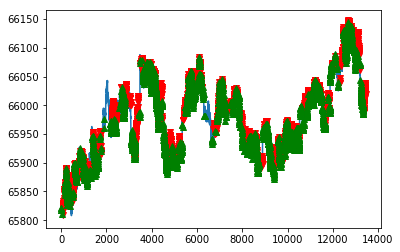

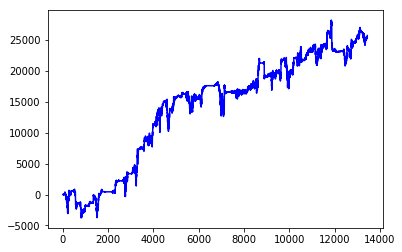

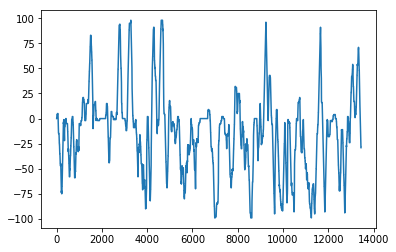

(25375.0, 5.366, 1.883)

In [33]:
back_test(tolerance=0.4,take_profit=30,stop_loss_time=100)


In [34]:
#здесь другой алгоритм - при превышлении tolerance покупаем, 
#при -tolerance продаем вселонги  что набрали и начинаем набирать позу в другую сторону
def back_test_2(tolerance,take_profit=0,stop_loss_time=0,last = 0, show_graphs = True):
    exe = Executor()
    exe.on_price_prob = 1
    exe.out_order_delta = 20
    exe.max_position = 100
    test = test_predicted_labels[-last:]
    
    l= len(test)
    print(l)
    test_data = df[-l:]
    test_price = price_l[-l:]

    for t in range(l):
        price = test_price[t]
        betta = test[t]
        if betta>tolerance and not exe.order_on_price(price):
            if exe.quantity>=0:
                exe.add_order(price,1)
            else:
                exe.add_order(price,-exe.quantity)
        elif betta<-tolerance and not exe.order_on_price(price):
            if exe.quantity<=0:
                
                exe.add_order(price,-1)
            else:
                exe.add_order(price,-exe.quantity)
        exe.update(price)
    if show_graphs:
        exe.plot_stat_3()
    return round(exe.r_pnl,2),round(exe.get_ppd(),3),abs(round(exe.get_profit_factor(),3))

13448


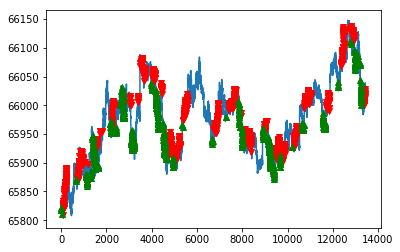

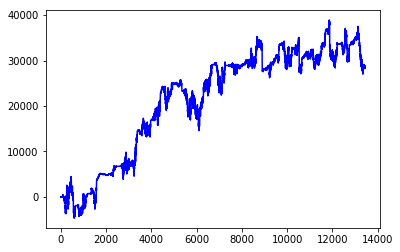

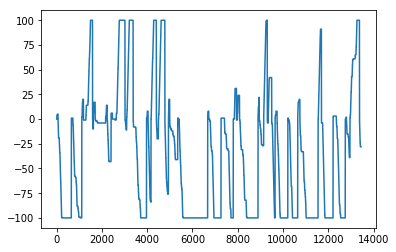

(29065.0, 10.579, 2.519)

In [35]:
back_test_2(0.4,last=0)


In [36]:
#попробовать модель обучить на 20-ках, а применить на 10-ках